This notebook is a vewrsion of the original notebook. Instead of preparing the data by padding and masking smaller batches of time series of the trajectories are prepared and fed to the network

Notebook for the GoogleDecimeterChallenge https://www.kaggle.com/competitions/smartphone-decimeter-2023


Also try to run it on google collab, works great only RAM is limited:
https://colab.research.google.com/github/Torbynator/GoogleDecimeterChallenge/blob/main/main.ipynb#scrollTo=TOn-Can4C0YP

#Only for google collab
from google.colab import drive
drive.mount('/content/drive')
!pip install  kaggle
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!kaggle competitions download -c smartphone-decimeter-2023
!unzip /content/smartphone-decimeter-2023.zip

In [1]:
#reading data
import numpy as np 
import pandas as pd
from tqdm import tqdm, trange
import math
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import optuna	

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking
from tensorflow.keras.backend import clear_session
from tensorflow.keras.optimizers import Adam
from livelossplot import PlotLossesKeras

INPUT_PATH = 'sdc2023/'



In [2]:


# test_input_data = []
# test_gt_data = []

# #iterate over all data files and store them in the respective arrays

# #load test data
# test_files = os.listdir(INPUT_PATH + "test")

# for folder in test_files:
#     smartphones = os.listdir(INPUT_PATH + "test/"+folder)
#     for smartphone in smartphones:
#         file =  "/device_gnss.csv"
#         #store data in list while dropping first and 41st column (string data)
#         test_input_data.append(pd.read_csv(INPUT_PATH + "test/" +folder+"/"+smartphone + file, usecols=[i for i in range(58) if i not in [0,40]], dtype=np.float32).to_numpy(dtype=np.float32).tolist())


In [3]:
#load train data

def read_data(MAX_TRAJECTORIES):
    train_files = os.listdir(INPUT_PATH + "train")
    trajectory_count=0
    used_columns = ["utcTimeMillis","RawPseudorangeMeters", "RawPseudorangeUncertaintyMeters" ,"SvPositionXEcefMeters" ,"SvPositionYEcefMeters", "SvPositionZEcefMeters", "IsrbMeters"]

    train_input_data = []
    train_gt_data = []

    for folder in train_files:
        smartphones = os.listdir(INPUT_PATH + "train/"+folder)
        for smartphone in smartphones:
            files = os.listdir(INPUT_PATH + "train/"+folder+"/"+smartphone)
            for file in files:
                if file.endswith(".csv"):
                    if trajectory_count >= MAX_TRAJECTORIES:
                        break   
                    if "gnss" in file:
                        #store data in list while dropping first and 41st column (string data), as well as (porbably mostly) empty columns
                        #also all data points with the same timestep are seen as features of one timestep of a sample
                        sample = pd.read_csv(INPUT_PATH + "train/" +folder+"/"+ smartphone+ "/" + file, usecols=used_columns, dtype=float).to_numpy(dtype=float)
                        #correct PseudoRange with ISRB
                        sample[:,1] = sample[:,1] + sample[:,6]
                        train_input_data.append(sample)
                    elif "ground_truth" in file:
                        trajectory_count +=1
                        #store data in list while dropping first and 2nd column (string data),(porbably mostly) empty columns
                        train_gt_data.append(pd.read_csv(INPUT_PATH + "train/"+folder+"/" + smartphone+ "/" + file,  usecols=[i for i in range(9) if i not in [0,1]], dtype=float).to_numpy(dtype=float).tolist())
                        print(f"read in {trajectory_count} samples")

    #delete IRSB column
    train_input_data = [sample[:,:6] for sample in train_input_data]

    #replace NaN values with 0
    train_input_data = [[[0 if math.isnan(x) else x for x in timestep] for timestep in sample ] for sample in train_input_data]

    return train_input_data, train_gt_data

In [4]:
#TIME_SERIES_SIZE = 50

def sort_data(TIME_SERIES_SIZE, train_input_data, train_gt_data):
    #move all features with the same timestamp to one line 
    for sample in range(len(train_input_data)):
        matches = 0
        print(f"sample {sample}")
        timesteps = 0
        for step in range(len(train_input_data[sample])):
            if step != 0:
                if train_input_data[sample][step-matches][0] == train_input_data[sample][step-1-matches][0]:
                    train_input_data[sample][step-1-matches].extend(train_input_data[sample][step-matches][1:])
                    train_input_data[sample].pop(step-matches)
                    matches +=1
                else:
                    timesteps+=1


    #prpare batches of time series of size TIME_SERIES_SIZE
    train_input_data_batched = [sample[i:i+TIME_SERIES_SIZE] for sample in train_input_data for i in range(0,len(sample)-TIME_SERIES_SIZE)]
    train_gt_data_batched = [sample[i:i+TIME_SERIES_SIZE] for sample in train_gt_data for i in range(0,len(sample)-TIME_SERIES_SIZE)]




    #pad input data
    max_features = max(max([len(feature) for sample in train_input_data_batched for feature in sample]),max([len(feature) for sample in train_gt_data_batched for feature in sample]))


    train_input_data_padded = [tf.keras.preprocessing.sequence.pad_sequences(sample,value=0, padding="post", dtype=np.float64, maxlen=max_features) for sample in train_input_data_batched]
    train_input_data_padded = np.array(train_input_data_padded)



    del train_input_data, train_input_data_batched

    #pad ground truth data
    max_features_gt = max(len(feature) for sample in train_gt_data_batched for feature in sample)

    #convert to right data format
    train_gt_data_padded = [tf.keras.preprocessing.sequence.pad_sequences(sample, value=0,padding="post", dtype=np.float64, maxlen=max_features_gt) for sample in train_gt_data_batched]
    train_gt_data_padded = np.array(train_gt_data_padded)
    del train_gt_data, train_gt_data_batched

    if(train_input_data_padded.shape[0] != train_gt_data_padded.shape[0]):
        while train_input_data_padded.shape[0] > train_gt_data_padded.shape[0]:
            train_input_data_padded = np.delete(train_input_data_padded, -1, axis=0)
        while train_input_data_padded.shape[0] < train_gt_data_padded.shape[0]:
            train_gt_data_padded = np.delete(train_gt_data_padded, -1, axis=0)

    print(train_input_data_padded.shape)
    print(train_gt_data_padded.shape)

    return train_input_data_padded, train_gt_data_padded


In [5]:
import sklearn.preprocessing as preprocess

def normalize_data(train_input_data_padded, train_gt_data_padded):
    #normalize data
    scaler = preprocess.MinMaxScaler()
    train_input_data_padded_normalized = []
    for sample in train_input_data_padded:
        data_range = []
        train_input_data_padded_normalized.append(scaler.fit_transform(sample))
    train_input_data_padded_normalized=np.array(train_input_data_padded_normalized)

    gt_scaler = preprocess.MinMaxScaler()
    train_gt_data_padded_normalized = []
    for sample in train_gt_data_padded:
        data_range = []
        train_gt_data_padded_normalized.append(gt_scaler.fit_transform(sample))
    train_gt_data_padded_normalized=np.array(train_gt_data_padded_normalized)

    return train_input_data_padded_normalized, train_gt_data_padded_normalized, scaler, gt_scaler


In [6]:



def measure(lat1, lon1, lat2, lon2):  # generally used geo measurement function
    R = 6378.137; # Radius of earth in KM
    dLat = lat2 * np.pi / 180 - lat1 * np.pi / 180
    dLon = lon2 * np.pi / 180 - lon1 * np.pi / 180
    a = np.sin(dLat/2) * np.sin(dLat/2) + np.cos(lat1 * np.pi / 180) * np.cos(lat2 * np.pi / 180) *  np.sin(dLon/2) * np.sin(dLon/2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = R * c
    return d * 10000; #decimeters


class DecimeterError(tf.keras.callbacks.Callback):
    def __init__(self):
        super(DecimeterError, self).__init__()

    def on_epoch_begin(self, epoch, logs=None):
        super().on_epoch_begin(epoch, logs)

    def on_epoch_end(self, epoch, logs=None):
        super().on_epoch_end(epoch, logs)
    
    def on_training_begin(self, logs=None):
        super().on_training_begin(logs)
    
    def on_batch_begin(self, batch, logs=None):
        super().on_batch_begin(batch, logs)


    def on_batch_end(self, batch, logs=None):
        super().on_batch_end(batch, logs)


    def on_training_end(self, epoch, logs=None):
        super().on_training_end(epoch, logs)
        ly_pred = self.model.predict(train_input_data_padded_normalized)
        ly_true = train_gt_data_padded_normalized
        ly_pred = np.array([gt_scaler.inverse_transform(sample) for sample in ly_pred])
        ly_true = np.array([gt_scaler.inverse_transform(sample) for sample in ly_true])
        error = measure(ly_pred[:,:,0], ly_pred[:,:,1], ly_true[:,:,0], ly_true[:,:,1])
        total_avg_error = np.mean(error)
        print(f"decimeter error: {total_avg_error}")





In [7]:

EPOCHS = 15
BATCH_SIZE = 32
SAMPLES = 60

def objective(trial):
    global train_input_data_padded_normalized, train_gt_data_padded_normalized, gt_scaler
    TIME_SERIES_SIZE = trial.suggest_int("TIME_SERIES_SIZE", 10, 100)
    train_input_data, train_gt_data = read_data(SAMPLES)
    train_input_data_padded, train_gt_data_padded = sort_data(TIME_SERIES_SIZE, train_input_data, train_gt_data)
    train_input_data_padded_normalized, train_gt_data_padded_normalized, scaler, gt_scaler = normalize_data(train_input_data_padded, train_gt_data_padded)

    n_layers = trial.suggest_int("n_layers", 1, 6)
    activation = trial.suggest_categorical("activation", ["tanh", "relu"])
    model = Sequential()
    model.add(Masking(mask_value=0, input_shape=(train_input_data_padded_normalized.shape[1], train_input_data_padded_normalized.shape[2])))
    for i in range(n_layers):
        model.add(LSTM(trial.suggest_int(f"n_units_l{i}", 10, 100), activation=activation, return_sequences=True))
    model.add(Dense(7, activation="linear"))

    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)

    model.compile(optimizer=Adam(learning_rate), loss="MeanSquaredError")

    history = model.fit(train_input_data_padded_normalized, train_gt_data_padded_normalized, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[PlotLossesKeras()], validation_split=0.2, verbose=0)
    #return validation score as indicator for the model quality
    print(history.history["val_loss"][-1])
    return history.history["val_loss"][-1]
    
    



In [8]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

[I 2024-07-16 16:29:29,460] A new study created in memory with name: no-name-3bb19fe5-5fb6-4b3f-98a5-4252483935a5


read in 1 samples
read in 2 samples
read in 3 samples
read in 4 samples
read in 5 samples
read in 6 samples
read in 7 samples
read in 8 samples
read in 9 samples
read in 10 samples
read in 11 samples
read in 12 samples
read in 13 samples
read in 14 samples
read in 15 samples
read in 16 samples
read in 17 samples
read in 18 samples
read in 19 samples
read in 20 samples
read in 21 samples
read in 22 samples
read in 23 samples
read in 24 samples
read in 25 samples
read in 26 samples
read in 27 samples
read in 28 samples
read in 29 samples
read in 30 samples
read in 31 samples
read in 32 samples
read in 33 samples
read in 34 samples
read in 35 samples
read in 36 samples
read in 37 samples
read in 38 samples
read in 39 samples
read in 40 samples
read in 41 samples
read in 42 samples
read in 43 samples
read in 44 samples
read in 45 samples
read in 46 samples
read in 47 samples
read in 48 samples
read in 49 samples
read in 50 samples
read in 51 samples
read in 52 samples
read in 53 samples
re

[W 2024-07-16 16:32:17,146] Trial 0 failed with parameters: {'TIME_SERIES_SIZE': 93} because of the following error: MemoryError((160400, 93, 266), dtype('float64')).
Traceback (most recent call last):
  File "d:\OneDrive\Documents\Uni\Machine Learning in Mechanics\GoogleDecimeterChallenge\.venv\Lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\Torbe\AppData\Local\Temp\ipykernel_13280\646568441.py", line 9, in objective
    train_input_data_padded, train_gt_data_padded = sort_data(TIME_SERIES_SIZE, train_input_data, train_gt_data)
                                                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Torbe\AppData\Local\Temp\ipykernel_13280\1810936948.py", line 31, in sort_data
    train_input_data_padded = np.array(train_input_data_padded)
                              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
numpy.core._exception

MemoryError: Unable to allocate 29.6 GiB for an array with shape (160400, 93, 266) and data type float64

In [ ]:
save_path = "optuna_results"
study_name = "LSTM for GNSS"
os.makedirs(save_path, exist_ok=True)
save_study = optuna.create_study(study_name=study_name, storage=f"sqlite:///{save_path}/{study_name}.db")
save_study.add_trials(study.trials)
study.trials_dataframe().to_csv(f"{save_path}/{study_name}.csv")
print(study.best_params)

DuplicatedStudyError: Another study with name 'LSTM for GNSS' already exists. Please specify a different name, or reuse the existing one by setting `load_if_exists` (for Python API) or `--skip-if-exists` flag (for CLI).

In [ ]:
loaded_study = optuna.load_study(study_name=study_name, storage=f"sqlite:///{save_path}/{study_name}.db")
print(loaded_study.best_params)

{'TIME_SERIES_SIZE': 11, 'n_layers': 3, 'activation': 'relu', 'n_units_l0': 95, 'n_units_l1': 18, 'n_units_l2': 100, 'learning_rate': 1.8400133435737296e-05}


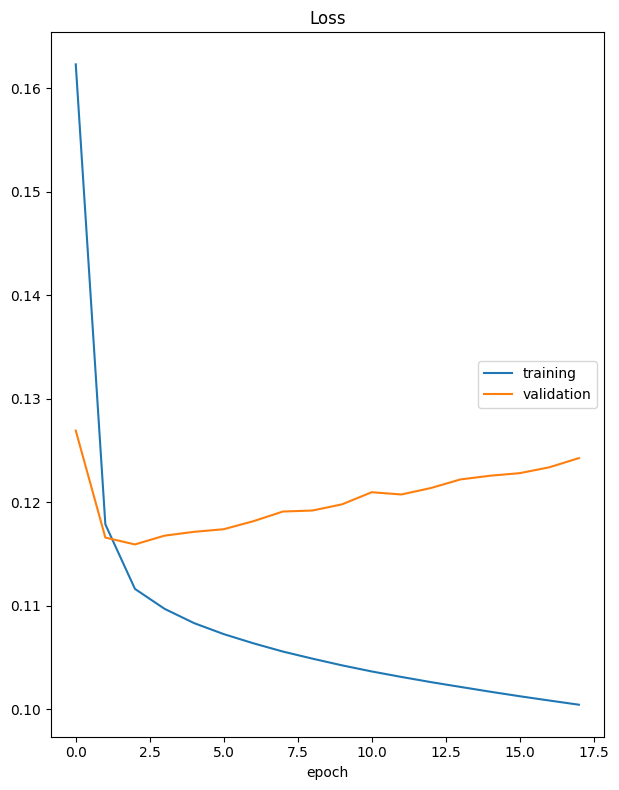

Loss
	training         	 (min:    0.100, max:    0.162, cur:    0.100)
	validation       	 (min:    0.116, max:    0.127, cur:    0.124)


KeyboardInterrupt: 

In [ ]:
#train model with best params
SAMPLES = 40
params = loaded_study.best_params

global train_input_data_padded_normalized, train_gt_data_padded_normalized, gt_scaler
TIME_SERIES_SIZE = params["TIME_SERIES_SIZE"]
train_input_data, train_gt_data = read_data(SAMPLES)
train_input_data_padded, train_gt_data_padded = sort_data(TIME_SERIES_SIZE, train_input_data, train_gt_data)
train_input_data_padded_normalized, train_gt_data_padded_normalized, scaler, gt_scaler = normalize_data(train_input_data_padded, train_gt_data_padded)

n_layers = params["n_layers"]
activation = params["activation"]
model = Sequential()
model.add(Masking(mask_value=0, input_shape=(train_input_data_padded_normalized.shape[1], train_input_data_padded_normalized.shape[2])))
for i in range(n_layers):
    model.add(LSTM(params[f"n_units_l{i}"] , activation=activation, return_sequences=True))
model.add(Dense(7, activation="linear"))

learning_rate = params["learning_rate"]

model.compile(optimizer=Adam(learning_rate), loss="MeanSquaredError")

history = model.fit(train_input_data_padded_normalized, train_gt_data_padded_normalized, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[PlotLossesKeras(), DecimeterError()], validation_split=0.2, verbose=0)
#return validation score as indicator for the model quality
print(history.history["val_loss"][-1])
